<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords 
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col = 0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [5]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


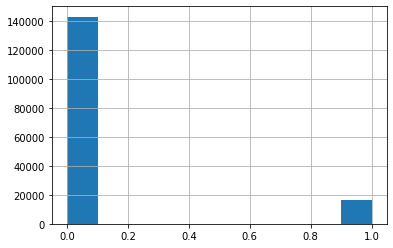

In [6]:
data['toxic'].hist();

In [7]:
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('english'))

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
def predproc(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [11]:
data['predproc'] = data['text'].apply(predproc)

In [12]:
data.head()

,text,toxic,predproc
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wondered sect...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


In [13]:
df = data.copy()
y = df['toxic']
df = df.drop(['toxic'], axis = 1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size = 0.3, stratify = y)

In [15]:
print('Train data shape:', x_train.shape, y_train.shape)
print('Test data shape:', x_test.shape, y_test.shape)

Train data shape: (111504, 2) (111504,)
Test data shape: (47788, 2) (47788,)


Данные обработаны, очищены от лишних символов, лемматизированы, векторизированы

## Обучение

In [16]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(x_train['predproc'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [17]:
lr_mod = training(LogisticRegression(), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.7766703989633029
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


In [18]:
dtc_mod = training(DecisionTreeClassifier(), {'model__criterion':['gini','entropy'],'model__max_depth':[2,4,6]})

Лучший результат: 0.5376744940681708
Лучшие параметры: {'model__criterion': 'entropy', 'model__max_depth': 6}


In [19]:
cat_mod = training(CatBoostClassifier(logging_level='Silent'), {'model__depth': [4,6],
                 'model__learning_rate' : [0.01,0.03],
                  'model__iterations' : [10, 50]})

Лучший результат: 0.5218616543829252
Лучшие параметры: {'model__depth': 6, 'model__iterations': 50, 'model__learning_rate': 0.03}


На тренировочной выборке лучший результат у LogisticRegression, поэтому протестируем её на тестовой выборке

In [21]:
res = f1_score(y_test, lr_mod.predict(x_test['predproc']))

In [22]:
print("Результат LogisticRegression", res)

Результат LogisticRegression 0.7781099103242125


## Выводы

Самый высокий f1 у LogisticRegression